In [1]:
# classical Hamiltonians for the win!

from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
from jax import jit, lax, vmap, grad, jacobian, random, pmap
from jax.experimental import ode

import numpy as np
from read_traj import *

import matplotlib
import matplotlib.pyplot as plt

import scipy.optimize
#import optax
import time
#import haiku as hk


In [2]:
dt = 0.82680
mynumsteps = 150
ntvec = mynumsteps
drc = 2
m = drc

print('reading new data')
allden = np.load('tdci_heh+_AO_diagonalized_cycle.npz')
allden = np.real(allden)
print('done reading new data')
print(allden.shape)

reading new data
done reading new data
(99, 690, 2, 2)


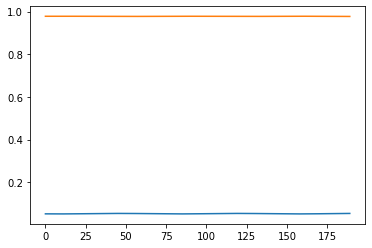

In [3]:
# explore data
plt.plot(allden[0,500:1000,0,0])
plt.plot(allden[0,500:1000,1,1])
plt.show()

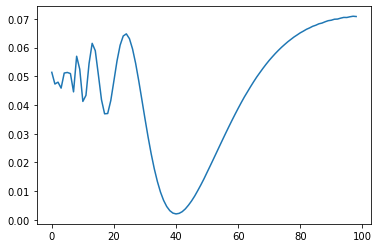

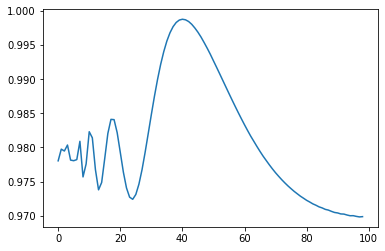

In [4]:
# plots showing all initial conditions are pretty much the same!
plt.plot(allden[:,0,0,0])
plt.show()
plt.plot(allden[:,0,1,1])
plt.show()

In [5]:
allden.shape

(99, 690, 2, 2)

In [6]:
# form an nsteps x 2 vector containing the diagonal elements, forced to be real
offset = 0
jallden = jnp.stack([ np.real(allden[0,offset:,0,0]), np.real(allden[0,offset:,1,1]) ], axis=1)

# now square root this and multiply top one by -1
# jallden = jnp.sqrt(jallden) # * jnp.array([[-1.0,1.0]])

# center oscillations about 0
jallden -= jnp.mean(jallden,axis=0)

# make them have amplitude 1
jallden /= jnp.max(jnp.abs(jallden),axis=0)

print(jallden[:10,:])


[[-0.87511817  0.8751182 ]
 [-0.83137469  0.83137463]
 [-0.78181761  0.78181755]
 [-0.72689732  0.72689735]
 [-0.66708657  0.66708655]
 [-0.60288388  0.6028838 ]
 [-0.53479897  0.53479896]
 [-0.46335348  0.46335345]
 [-0.38906929  0.38906922]
 [-0.31247704  0.31247702]]


In [7]:
jallden.shape

(690, 2)

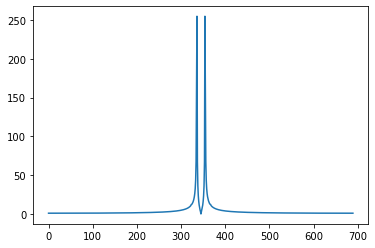

In [8]:
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(jallden[:,0]))))
plt.show()

In [25]:
np.abs(np.fft.fft(jallden[:,0]))[200:300]

array([1.16722061, 1.16308017, 1.15899124, 1.15498468, 1.15100584,
       1.14711574, 1.14322515, 1.13942228, 1.13566269, 1.13196394,
       1.12828759, 1.12463788, 1.12104752, 1.11754889, 1.11405514,
       1.11062863, 1.10721818, 1.10393584, 1.10056079, 1.09730434,
       1.09407055, 1.09089443, 1.08773513, 1.08467192, 1.08156102,
       1.07857816, 1.07562518, 1.07263433, 1.06975184, 1.06686855,
       1.0640539 , 1.0612533 , 1.05849615, 1.05578287, 1.05307379,
       1.0504219 , 1.04784815, 1.04528234, 1.04267858, 1.04021079,
       1.03771812, 1.03529484, 1.0328802 , 1.03049273, 1.02811969,
       1.02582505, 1.02351427, 1.02130103, 1.01909435, 1.01690052,
       1.01475124, 1.01259634, 1.01049003, 1.00845691, 1.00640681,
       1.00439186, 1.00240885, 1.00041526, 0.99851958, 0.99664876,
       0.99478668, 0.99295702, 0.99111061, 0.98933184, 0.98758091,
       0.98581027, 0.98415599, 0.98247146, 0.98079192, 0.97917316,
       0.97758311, 0.97601039, 0.97443835, 0.972954  , 0.97145

In [26]:
# classical Hamiltonian
numparams = 1

def ham(theta, q, p):
    ham = p**2/2.0
    # Fourier!
    # ham += jnp.sum(theta[1:]**2 * jnp.cos((jnp.arange(numparams-1)+1)*q))
    # form a polynomial by hand
    ham += theta[0]**2 * q**2/2.0
    # ham += theta[2]**2 * q**4/24.0
    # ham += theta[3]**2 * p**2 * q**2 / 4.0
    return ham

In [27]:
# derivatives of Hamiltonian
dHdtheta = grad(ham, 0)
dHdq = grad(ham, 1)
dHdp = grad(ham, 2)

In [28]:
# Hamilton's equations as a vector field
def hamvf(y, t, theta):
    q = y[0]
    p = y[1]
    qdot = dHdp(theta, q, p)
    pdot = -dHdq(theta, q, p)
    return jnp.array([qdot, pdot])

In [29]:
# use built-in jax numerical integrator to generate trajectory for theta
def gentraj(mytheta):
    ic = jnp.array([jallden[0,0],0.0])
    tvec = jnp.arange(mynumsteps+1)*dt
    mysol = ode.odeint(hamvf, ic, tvec, mytheta, rtol=1e-12, atol=1e-12)
    return mysol

In [30]:
# form loss function
def loss(mytheta):
    pred = gentraj(mytheta)
    return jnp.mean(jnp.square(pred[:,0] - jallden[:(mynumsteps+1),0]))

In [31]:
jallden.shape

(690, 2)

In [32]:
# JIT and GRAD and all that JAX
jloss = jit(loss)

gradloss = grad(loss)
jgradloss = jit(gradloss)

In [33]:
# WRAPPERS TO ENABLE USE OF SCIPY OPTIMIZERS
def siobj(x):
    return jloss(jnp.array(x)).item()

def sigrad(x):
    return np.array(jgradloss(jnp.array(x)))

In [34]:
# theta0 = 0.00001*np.random.normal(size=numparams)
# res = scipy.optimize.minimize( siobj, 
#                                x0 = np.array(theta0),
#                                method = 'L-BFGS-B',
#                                jac = sigrad,
#                                options = {'iprint': 1, 'ftol': 1e-8, 'gtol': 1e-8} )
# trainedtheta = res.x

In [35]:
vloss = vmap(loss)
jvloss = jit(vloss)

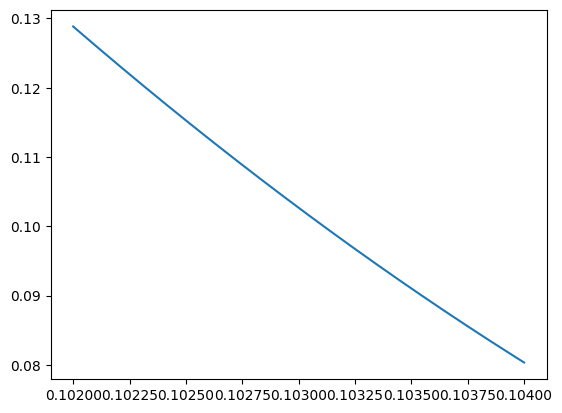

In [36]:
numthetas = 1500
thetaspace = jnp.expand_dims(jnp.linspace(0.102,0.104, numthetas),1)
lossspace = jvloss(thetaspace)
plt.plot(thetaspace,lossspace)
plt.show()

In [37]:
# theta0 = np.array([np.sqrt(0.50),0.045,0.0])
theta0 = np.array([0.103])
res = scipy.optimize.minimize( siobj, 
                               x0 = theta0,
                               method = 'trust-constr',
                               hess = scipy.optimize.SR1(),
                               jac = sigrad,
                               options = {'disp': True, 'verbose': 2, 'maxiter': 1000,
                                          'xtol': 1e-8, 'gtol': 1e-8} )
trainedtheta = res.x

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +1.0268e-01 | 1.00e+00 | 2.42e+01 | 0.00e+00 |
|   2   |   2   |   1   | +1.0268e-01 | 5.00e-01 | 2.42e+01 | 0.00e+00 |
|   3   |   3   |   2   | +1.0268e-01 | 2.50e-01 | 2.42e+01 | 0.00e+00 |
|   4   |   4   |   3   | +1.0268e-01 | 1.25e-01 | 2.42e+01 | 0.00e+00 |
|   5   |   5   |   4   | +1.0268e-01 | 6.25e-02 | 2.42e+01 | 0.00e+00 |
|   6   |   6   |   5   | +1.0268e-01 | 3.12e-02 | 2.42e+01 | 0.00e+00 |
|   7   |   7   |   6   | +1.0268e-01 | 1.44e-02 | 2.42e+01 | 0.00e+00 |
|   8   |   8   |   7   | +1.0268e-01 | 7.18e-03 | 2.42e+01 | 0.00e+00 |
|   9   |   9   |   8   | +2.9546e-02 | 1.44e-02 | 4.27e+00 | 0.00e+00 |
|  10   |  10   |   9   | +2.7339e-02 | 1.44e-02 | 6.71e-02 | 0.00e+00 |
|  11   |  11   |  10   | +2.7338e-02 | 1.44e-02 | 4.25e-04 | 0.00e+00 |
|  12   |  12   |  11   | +2.7338e-02 | 1.44e-02 | 

In [38]:
res.x

array([0.10914774])

In [39]:
# theta0 = np.concatenate([np.array([1.0,0.072]), np.zeros(numparams-2)])
trainedpredtraj = gentraj(res.x)

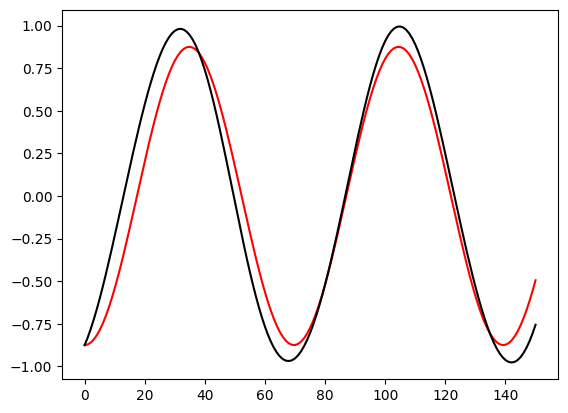

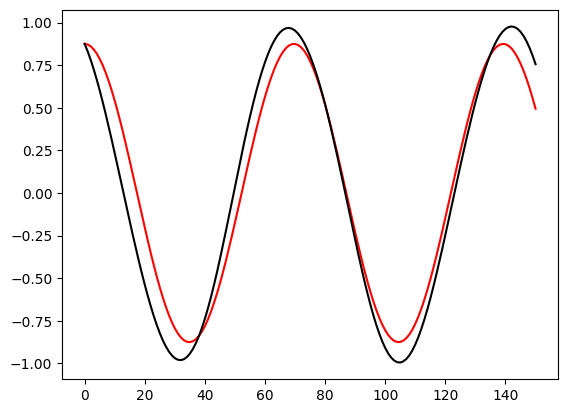

In [40]:
plt.plot(trainedpredtraj[:,0], color='red')
plt.plot(jallden[:(mynumsteps+1),0],color='black')
plt.show()

plt.plot(-trainedpredtraj[:,0], color='red')
plt.plot(jallden[:(mynumsteps+1),1],color='black')
plt.show()